## Вспомогательные функции

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Импортирование необходимых библиотек.

In [2]:
import gzip
import math
import os
import requests
import shutil
import urllib

from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import trange
from typing import Optional, Tuple, List, Sequence

import imageio

import numpy as np
import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader, ChainDataset, ConcatDataset
from torch.optim import Optimizer

from torchvision import transforms
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.utils import save_image

from IPython import display
from IPython.display import Image

Вспомогательные функции для скачивания набора данных MNIST.

In [3]:
DATA_ROOT = './data'
MNIST_FILES = {
    'mnist_data_train': 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'mnist_data_test': 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
}

def _download(url, filename):
    if not os.path.exists(DATA_ROOT):
        os.makedirs(DATA_ROOT)

    out_file = os.path.join(DATA_ROOT, f'{filename}.gz')
    if not os.path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print(f'Downloaded {url} to {out_file}')
    else:
        print(f'{out_file} already downloaded')

def _unpack_and_save_to_npy(filename):
    gzip_file = os.path.join(DATA_ROOT, f'{filename}.gz')
    npy_file = os.path.join(DATA_ROOT, f'{filename}.npy')

    if os.path.isfile(npy_file):
        print(f'{npy_file} already exists')
        return

    with gzip.open(gzip_file, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    np.save(npy_file, data)
    print(f'Unpacked {gzip_file} to {npy_file}')

def _fetch_data(files):
    for filename, url in files.items():
        _download(url, filename)
        _unpack_and_save_to_npy(filename)

In [4]:
_fetch_data(MNIST_FILES)

./data/mnist_data_train.gz already downloaded
./data/mnist_data_train.npy already exists
./data/mnist_data_test.gz already downloaded
./data/mnist_data_test.npy already exists


Вспомогательные функции для использования моделей.

In [5]:
def extract_by_time(a, time, x_ndim):
    out = a[time]
    return out.reshape(-1, *((1,) * (x_ndim - 1))).to(time.device)

def sample_noise_batch(batch_size):
    noise_batch = torch.randn(batch_size, 1, image_size, image_size)
    if use_cuda:
        noise_batch = noise_batch.cuda()
    return noise_batch

def get_full_backward_diffusion_process(model, noise):
    with torch.no_grad():
        batch_size = noise.shape[0]
        x_ndim = noise.ndim

        intermediates = list()
        x = noise
        intermediates.append(x)
        for step in reversed(list(range(0, num_timesteps))):
            t = torch.full((batch_size,), step, dtype=torch.long)
            if use_cuda:
                t = t.cuda()

            betas_t = extract_by_time(betas, t, x_ndim)
            sqrt_recip_alphas_t = extract_by_time(sqrt_recip_alphas, t, x_ndim)
            sqrt_one_minus_alphas_cumprod_t = extract_by_time(sqrt_one_minus_alphas_cumprod, t, x_ndim)

            model_noise = model(x, t)
            model_mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * model_noise)

            x_prev = model_mean
            intermediates.append(x_prev)
            if not step == 0:
                posterior_variance_t = extract_by_time(posterior_variance, t, x_ndim)
                noise = torch.randn_like(x)
                x_prev = model_mean + posterior_variance_t.sqrt() * noise

            x = x_prev

    return intermediates

Вспомогательные функции для мониторинга обучения.

In [6]:
def make_and_save_results(step, losses):
    make_and_save_fixed_noise_images(step)
    make_and_save_random_noise_images(step)
    make_and_save_loss_plot(losses)

def make_and_save_fixed_noise_images(step: int):
    model.eval()
    x = model.make_backward_diffusion(noise=fixed_noise)
    x = torch.clamp((x + 1.) / 2., 0, 1)
    image_path = os.path.join(results_dir, 'fixed_noise_images', f'step_{step:05d}.png')
    save_image(x, image_path, nrow=4, padding=4, pad_value=1)

def make_and_save_random_noise_images(step):
    model.eval()
    noise = sample_noise_batch(16)
    x = model.make_backward_diffusion(noise)

    x = torch.clamp((x + 1.) / 2., 0, 1)
    image_path = os.path.join(results_dir, 'random_noise_images', f'step_{step:05d}.png')
    save_image(x, image_path, nrow=4, padding=4, pad_value=1)

def make_and_save_loss_plot(losses):
    plt.plot(losses, c='darkred')
    plt.grid()

    figure_path = os.path.join(results_dir, 'loss_fig.png')
    plt.savefig(figure_path)
    plt.clf();

In [7]:
def create_or_clean_results_dir():
    if os.path.exists(results_dir):
        shutil.rmtree(results_dir)
    os.makedirs(results_dir)

    os.makedirs(os.path.join(results_dir, 'checkpoints'))
    os.makedirs(os.path.join(results_dir, 'fixed_noise_images'))
    os.makedirs(os.path.join(results_dir, 'random_noise_images'))

In [8]:
results_dir = './results'
# create_or_clean_results_dir()

Вспомогательные функции для отрисовки результатов обучения.

In [9]:
def make_gif_file(images_folder, gif_file):
    with imageio.get_writer(gif_file, mode='I') as writer:
        filenames = os.listdir(images_folder)
        filenames = sorted(filenames)
        for filename in filenames:
            image_file = os.path.join(images_folder, filename)
            image = imageio.v2.imread(image_file)
            writer.append_data(image)
        image = imageio.v2.imread(image_file)
        writer.append_data(image)

In [10]:
fixed_noise_images_folder = os.path.join(results_dir, 'fixed_noise_images')
fixed_noise_images_gif = os.path.join(results_dir, 'fixed_noise_images.gif')

In [11]:
def make_gif_files():
    make_gif_file(fixed_noise_images_folder, fixed_noise_images_gif)

In [12]:
def show_gif(gif_file, size=None):
    if size is None:
        return Image(open(gif_file,'rb').read())
    else:
        width, height = size
        return Image(open(gif_file, 'rb').read(), width=width, height=height)

In [13]:
torch.set_printoptions(precision=6, threshold=15)
use_cuda = torch.cuda.is_available()
image_size = 28

## Подготовка данных

In [20]:
data_train_file = './data/mnist_data_train.npy'
data_test_file = './data/mnist_data_test.npy'

def preprocess_data(data):
    data = np.float32(data) / 255.
    data = data * 2. - 1.
    return data

In [21]:
data = np.load(data_train_file)[:, :, :, None]
data = preprocess_data(data)

In [22]:
type(data), data.shape, data.min(), data.max()

(numpy.ndarray, (60000, 28, 28, 1), -1.0, 1.0)

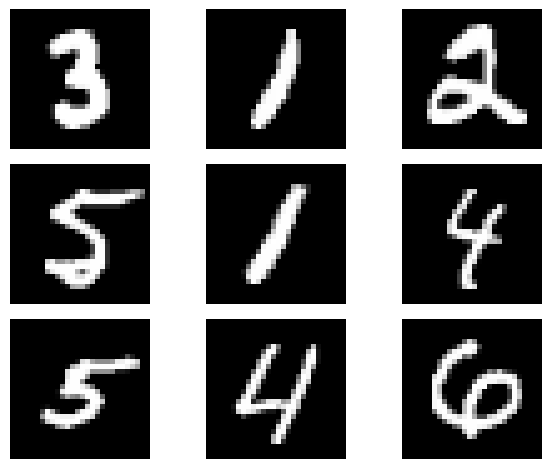

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=3)
for i in range(len(axes)):
    for j in range(len(axes[0])):
        idx = np.random.randint(0, len(data))
        image = data[idx]
        axes[i][j].imshow(image, cmap='Greys_r', interpolation='none')
        axes[i][j].set_axis_off()

plt.tight_layout()
plt.show()

## Расписане шума

In [25]:
def linear_beta_schedule(num_timesteps: int):
    beta_start = 1e-4 * (1000 / num_timesteps)
    beta_end = 0.02 * (1000 / num_timesteps)
    betas = torch.linspace(beta_start, beta_end, num_timesteps)
    return betas

In [26]:
num_timesteps = 600
betas = linear_beta_schedule(num_timesteps)
betas

tensor([0.000167, 0.000222, 0.000277,  ..., 0.033223, 0.033278, 0.033333])

In [27]:
alphas = 1 - betas
sqrt_recip_alphas = torch.rsqrt(alphas)
alphas_cumprod = torch.cumprod(alphas, dim=0)

sqrt_alphas_cumprod = alphas_cumprod.sqrt()
sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod).sqrt()
print(sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, sep='\n')

tensor([0.999917, 0.999806, 0.999667,  ..., 0.006422, 0.006315, 0.006209])
tensor([0.012909, 0.019714, 0.025806,  ..., 0.999979, 0.999980, 0.999981])


In [28]:
def get_xt(x, t):
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]

    mean = sqrt_alphas_cumprod_t * x
    std = torch.randn_like(x) * sqrt_one_minus_alphas_cumprod_t
    return mean + std

In [29]:
x = torch.tensor(data[13], dtype=torch.float32)
timesteps = [0, 39, 79, 119, 159, 199, 599]

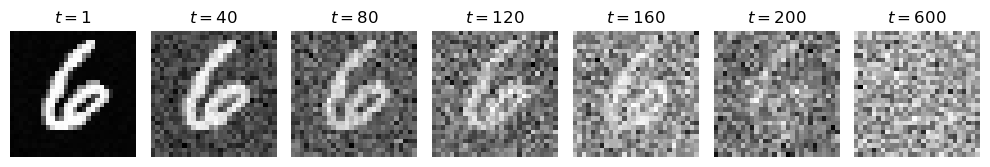

In [30]:
fig, axes = plt.subplots(1, len(timesteps), figsize=(10, 8))

for ax, t in zip(axes, timesteps):
    xt = get_xt(x, t)

    ax.imshow(xt, interpolation='none', cmap='Greys_r')
    ax.set_title(f'$t = {t + 1}$')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=1.65)
plt.show();

In [26]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)

In [27]:
if use_cuda:
    betas = betas.cuda()
    alphas = alphas.cuda()
    sqrt_recip_alphas = sqrt_recip_alphas.cuda()
    alphas_cumprod = alphas_cumprod.cuda()

    sqrt_alphas_cumprod = sqrt_alphas_cumprod.cuda()
    sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.cuda()

    alphas_cumprod_prev = alphas_cumprod_prev.cuda()
    posterior_variance = posterior_variance.cuda()

## Позиционное кодирование

In [28]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        denom = torch.exp(-torch.arange(self.dim) * math.log(10000) / self.dim)
        if use_cuda:
            denom = denom.cuda()

        embeddings = t[:, None] * denom[None, :]
        embeddings[:, ::2] = embeddings[:, ::2].sin()
        embeddings[:, 1::2] = embeddings[:, 1::2].cos()

        return embeddings

In [29]:
pos_embedder = SinusoidalPositionEmbeddings(128)

In [30]:
timesteps = torch.arange(0, num_timesteps)
if use_cuda:
    timesteps = timesteps.cuda()
pos_embeddings = pos_embedder(timesteps)

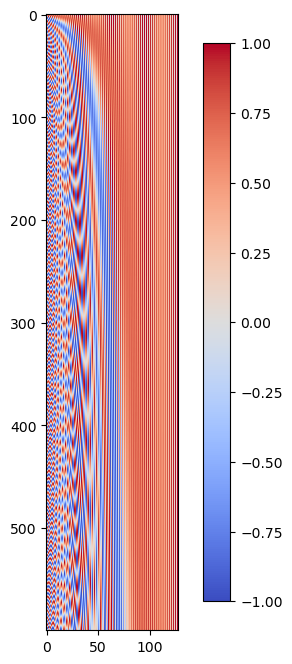

In [31]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(pos_embeddings.cpu(), cmap='coolwarm')
plt.colorbar(fraction=0.045, pad=0.04);

## Нейронная модель

In [32]:
class Block(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, num_groups: int):
        super().__init__()

        self.conv2d = nn.Conv2d(in_dim, out_dim, 3, padding=1)
        self.gn = nn.GroupNorm(num_groups, out_dim)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift: Optional[Tuple] = None):
        x = self.conv2d(x)
        x = self.gn(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (1 + scale) + shift

        x = self.act(x)
        return x


class ResNetBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, num_groups: int, time_emb_dim: Optional[int]):
        super().__init__()

        self.time_emb_proj = (
            nn.Linear(time_emb_dim, 2 * out_dim)
            if time_emb_dim is not None
            else None
        )

        self.block1 = Block(in_dim, out_dim, num_groups)
        self.block2 = Block(out_dim, out_dim, num_groups)
        self.res_proj = nn.Conv2d(in_dim, out_dim, 1) if in_dim != out_dim else None

    def forward(self, x, time_emb=None):
        scale_shift = None
        if self.time_emb_proj is not None:
            time_emb = self.time_emb_proj(time_emb)  # [B, С]
            time_emb = time_emb[:, :, None, None]
            scale_shift = time_emb.chunk(2, dim=1)

        out = self.block1(x, scale_shift=scale_shift)
        out = self.block2(out)
        if self.res_proj is not None:
            x = self.res_proj(x)

        return x + out


class Downsample(nn.Module):
    def __init__(self, dim: int, dim_out: int):
        super().__init__()
        self.downsample = nn.PixelUnshuffle(downscale_factor=2)
        self.proj = nn.Conv2d(dim * 4, dim_out, kernel_size=1)

    def forward(self, x):
        return self.proj(self.downsample(x))


class Upsample(nn.Module):
    def __init__(self, dim: int, dim_out: int):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.proj = nn.Conv2d(dim, dim_out, kernel_size=3, padding=1)

    def forward(self, x):
        return self.proj(self.upsample(x))

In [33]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_embedder = nn.Sequential(
            SinusoidalPositionEmbeddings(128),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU()
        )

        self.init_conv = nn.Conv2d(1, 32, kernel_size=1)

        self.down1 = nn.ModuleList([
            ResNetBlock(in_dim=32, out_dim=32, num_groups=8, time_emb_dim=128),
            ResNetBlock(in_dim=32, out_dim=32, num_groups=8, time_emb_dim=128),
            Downsample(dim=32, dim_out=32)
        ])

        self.down2 = nn.ModuleList([
            ResNetBlock(in_dim=32, out_dim=32, num_groups=8, time_emb_dim=128),
            ResNetBlock(in_dim=32, out_dim=32, num_groups=8, time_emb_dim=128),
            Downsample(dim=32, dim_out=64)
        ])

        self.down3 = nn.ModuleList([
            ResNetBlock(in_dim=64, out_dim=64, num_groups=8, time_emb_dim=128),
            ResNetBlock(in_dim=64, out_dim=64, num_groups=8, time_emb_dim=128),
            nn.Conv2d(64, 128, kernel_size=3, padding=1)
        ])

        self.mid = ResNetBlock(in_dim=128, out_dim=128, num_groups=8, time_emb_dim=128)

        self.up1 = nn.ModuleList([
            ResNetBlock(in_dim=64 + 128, out_dim=128, num_groups=8, time_emb_dim=128),
            ResNetBlock(in_dim=64 + 128, out_dim=128, num_groups=8, time_emb_dim=128),
            Upsample(128, 64)
        ])

        self.up2 = nn.ModuleList([
            ResNetBlock(in_dim=32 + 64, out_dim=64, num_groups=8, time_emb_dim=128),
            ResNetBlock(in_dim=32 + 64, out_dim=64, num_groups=8, time_emb_dim=128),
            Upsample(64, 32)
        ])

        self.up3 = nn.ModuleList([
            ResNetBlock(in_dim=32 + 32, out_dim=32, num_groups=8, time_emb_dim=128),
            ResNetBlock(in_dim=32 + 32, out_dim=32, num_groups=8, time_emb_dim=128),
            nn.Conv2d(32, 32, kernel_size=3, padding=1)
        ])

        self.final_block = ResNetBlock(in_dim=32 + 32, out_dim=32, num_groups=8, time_emb_dim=None)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x, time):
        x = self.init_conv(x)
        x_init = x.clone()
        time_emb = self.time_embedder(time)

        hs = []
        for block1, block2, downsample in [self.down1, self.down2, self.down3]:
            x = block1(x, time_emb)
            hs.append(x)

            x = block2(x, time_emb)
            hs.append(x)

            x = downsample(x)

        x = self.mid(x, time_emb)

        for (block1, block2, upsample) in [self.up1, self.up2, self.up3]:
            x = torch.cat([x, hs.pop()], dim=1)
            x = block1(x, time_emb)

            x = torch.cat([x, hs.pop()], dim=1)
            x = block2(x, time_emb)

            x = upsample(x)

        x = torch.cat([x, x_init], dim=1)
        x = self.final_block(x)
        x = self.final_conv(x)

        return x

## Диффузия

In [34]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = UNet()

    def forward(self, x, t):
        return self.net(x, t)

    def make_forward_diffusion(self, x_0, t):
        noise = torch.randn_like(x_0)

        x_ndim = x_0.ndim
        q_mean = extract_by_time(sqrt_alphas_cumprod, t, x_ndim) * x_0
        q_std = extract_by_time(sqrt_one_minus_alphas_cumprod, t, x_ndim)

        x_t = q_mean + q_std * noise
        return x_t, noise

    @torch.no_grad()
    def make_backward_diffusion_step(self, x, t, is_last_step: bool):
        x_ndim = x.ndim
        betas_t = extract_by_time(betas, t, x_ndim)
        sqrt_recip_alphas_t = extract_by_time(sqrt_recip_alphas, t, x_ndim)
        sqrt_one_minus_alphas_cumprod_t = extract_by_time(sqrt_one_minus_alphas_cumprod, t, x_ndim)

        model_noise = self.net(x, t)
        model_mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * model_noise)

        x_prev = model_mean
        if not is_last_step:
            posterior_variance_t = extract_by_time(posterior_variance, t, x_ndim)
            noise = torch.randn_like(x)
            x_prev = model_mean + posterior_variance_t.sqrt() * noise

        return x_prev

    @torch.no_grad()
    def make_backward_diffusion(self, noise: torch.Tensor):
        batch_size = noise.shape[0]
        x_recon = noise
        for step in reversed(list(range(0, num_timesteps))):
            t = torch.full((batch_size,), step, dtype=torch.long)
            if use_cuda:
                t = t.cuda()
            x_recon = self.make_backward_diffusion_step(x_recon, t, is_last_step=step == 0)

        return x_recon

In [35]:
model = DiffusionModel()

## Функции обучения

In [36]:
def sample_data_batch(batch_size):
    idxs = np.random.randint(0, len(data), size=(batch_size,))
    data_batch = torch.tensor(data[idxs]).permute(0, 3, 1, 2)
    if use_cuda:
        data_batch = data_batch.cuda()
    return data_batch

def sample_time_batch(batch_size, num_timesteps):
    time_batch = torch.randint(0, num_timesteps, (batch_size,)).long()
    if use_cuda:
        time_batch = time_batch.cuda()

    return time_batch

In [37]:
def make_train_step(batch_size: int, num_timesteps: int):
    model.train()
    optimizer.zero_grad()

    data_batch = sample_data_batch(batch_size)
    time_batch = sample_time_batch(batch_size, num_timesteps)
    noised_data_batch, noise_batch = model.make_forward_diffusion(data_batch, time_batch)

    predicted_noise_batch = model(noised_data_batch, time_batch)
    loss = criterion(predicted_noise_batch, noise_batch)

    loss.backward()
    optimizer.step()

    return loss.item()


def train(
    num_steps: int,
    batch_size: int,
    make_and_save_results_every: int,
    num_timesteps: int
):
    if use_cuda:
        model.cuda()

    losses = []
    for step in (pbar := trange(num_steps)):
        loss = make_train_step(batch_size, num_timesteps)
        pbar.set_description(f'loss={loss:.5f}')
        losses.append(loss)

        if step % make_and_save_results_every == 0:
            make_and_save_results(step, losses)

            torch.save(
               model.state_dict(),
               os.path.join(results_dir, 'checkpoints', 'model.pt')
            )
    make_gif_files()

## Обучение

In [38]:
fixed_noise = torch.randn((16, 1, image_size, image_size))

if use_cuda:
    fixed_noise = fixed_noise.cuda()

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.SmoothL1Loss()

In [40]:
num_steps = 40_000
batch_size = 128
make_and_save_results_every = 500

train(num_steps, batch_size, make_and_save_results_every, num_timesteps)

  0%|          | 0/40000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

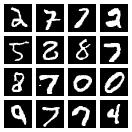

In [14]:
show_gif(fixed_noise_images_gif, size=(448, 448))

## Применение

In [42]:
model.eval();

In [43]:
noise = sample_noise_batch(1)

In [44]:
gen_data = model.make_backward_diffusion(noise)

In [45]:
gen_data_np = gen_data[0].permute(1, 2, 0).cpu().numpy()

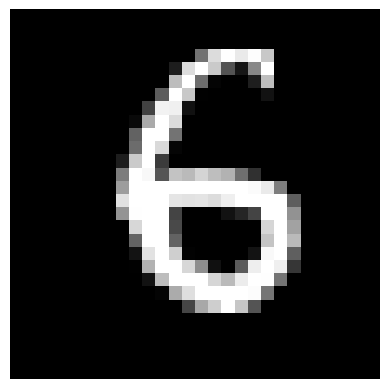

In [46]:
plt.imshow(gen_data_np, vmin=-1.0, vmax=1.0, cmap='Greys_r')
plt.axis('off')
plt.show()

In [56]:
xs_pred = get_full_backward_diffusion_process(model, noise)

In [57]:
timesteps = [599, 199, 159, 119, 79, 39, 0]

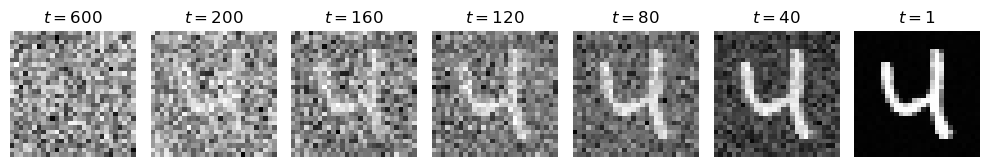

In [58]:
fig, axes = plt.subplots(1, len(timesteps), figsize=(10, 8))

for ax, t in zip(axes, timesteps):
    x_t_pred = xs_pred[num_timesteps - t - 1][0].permute(1, 2, 0).cpu().numpy()
    ax.imshow(x_t_pred, interpolation='none', cmap='Greys_r')
    ax.set_title(f'$t = {t + 1}$')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=1.65)
plt.show();